Analyze SBI-SGM, new bounds, new SGM, only three parameters needed

parameters order is  :tauG,speed,alpha (In second)

## Import some pkgs

In [107]:
import sys
sys.path.append("../../mypkg")

import scipy
import itertools

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import trange
from scipy.io import loadmat
from functools import partial
from easydict import EasyDict as edict

In [108]:
# SBI and torch
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import analysis
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as sutils

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.distributions.multivariate_normal import MultivariateNormal

In [109]:
# my own fns
from brain import Brain
from FC_utils import build_fc_freq_m
from constants import RES_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl
from utils.reparam import theta_raw_2out, logistic_np, logistic_torch
from utils.stable import paras_table_check

## Some fns

In [110]:
def _simulate_data(raw_params, brain, prior_bds, freqrange, diag_ws):
    params = []
    for raw_param, prior_bd in zip(raw_params, prior_bds):
        param =  _map_fn_torch(raw_param)*(prior_bd[1]-prior_bd[0]) + prior_bd[0]
        params.append(param)
    params = torch.tensor(params)
    
    params_dict = dict()
    params_dict["tauC"] =  params[0].item()
    params_dict["speed"] =  params[1].item()
    params_dict["alpha"] =  params[2].item()
    modelFC = build_fc_freq_m(brain , params_dict, freqrange, diag_ws)
    return np.abs(modelFC[:68, :68])

In [111]:
_minmax_vec = lambda x: (x-np.min(x))/(np.max(x)-np.min(x))

<function __main__.<lambda>(x)>

In [112]:
# transfer vec to a sym mat
def _vec_2mat(vec):
    mat = np.zeros((68, 68))
    mat[np.triu_indices(68, k = 1)] = vec
    mat = mat + mat.T
    return mat

In [113]:
# paras to model FC via sgm
def _paras_2FC(raw_params, brain, prior_bds, freqrange, diag_ws):
    params = []
    for raw_param, prior_bd in zip(raw_params, prior_bds):
        param =  _map_fn_torch(raw_param)*(prior_bd[1]-prior_bd[0]) + prior_bd[0]
        params.append(param)
    params = torch.tensor(params)
    
    params_dict = dict()
    params_dict["tauC"] =  params[0].item()
    params_dict["speed"] =  params[1].item()
    params_dict["alpha"] =  params[2].item()
    modelFC = build_fc_freq_m(brain , params_dict, freqrange, diag_ws)
    return modelFC[:68, :68]
    
#taue,taui,tauG,speed,alpha,gii,gei

In [114]:
def get_mode(x):
    kde_est = scipy.stats.gaussian_kde(x)
    xs = np.linspace(x.min(), x.max(), 500)
    ys = kde_est(xs)
    return xs[np.argmax(ys)]

### Some parameters

In [115]:
from scipy.io import loadmat
# The array is ordered as in ‘alpha’, ‘beta_l’, ‘delta’, ‘theta’
diag_ws = loadmat(DATA_ROOT/"diagonal_UFU.mat")["prjctFC_diag"];
diag_ws = np.abs(diag_ws).mean(axis=(1, 2))
diag_ws[0] = 0 # remove it
#diag_ws = np.ones(68)

In [116]:
# Parameter bounds for optimization
v_lower = 3.5-1.8
v_upper = 3.5+1.8
#bnds = ((0.005,0.030), (0.005,0.2), (0.005,0.030), (v_lower,v_upper), (0.1,1.0), (0.5,10.0), (0.5,10.0));
bnds = ((0.005,0.030), (v_lower,v_upper), (0.1,1.0));
#taue,taui,tauG,speed,alpha,gii,gei

In [117]:
_paras = edict()
_paras.delta = [2, 3.5]
_paras.theta = [4, 7]
_paras.alpha = [8, 12]
_paras.beta_l = [13, 20]


In [118]:
paras = edict()

paras.fc_type = "theta" #stick to coh
paras.freqrange =  np.linspace(_paras[paras.fc_type][0], _paras[paras.fc_type][1], 5)
paras.diag_ws = diag_ws
print(paras.freqrange)
paras.fs = 600
paras.num_nodes = 86 # Number of cortical (68) + subcortical nodes
#paras.par_low = np.asarray([0.005,0.005,0.005,5, 0.1,0.001,0.001])
#paras.par_high = np.asarray([0.03, 0.20, 0.03,20,  1,    2,  0.7])
paras.par_low = np.asarray([0.005, 5, 0.1])
paras.par_high = np.asarray([0.03, 20, 1])
paras.names = ["TauC", "Speed", "alpha"]
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.prior_sd = 10
paras.add_v = 0.05

paras.SBI_paras = edict()
paras.SBI_paras.num_prior_sps = int(1e3)
paras.SBI_paras.density_model = "nsf"
paras.SBI_paras.num_round = 3
paras.SBI_paras.noise_sd = 0.80
paras.SBI_paras.save_dir =  f"newsgm_posteriorMRmul_{paras.fc_type}_" + \
                            f"num{paras.SBI_paras.num_prior_sps}_" + \
                            f"density{paras.SBI_paras.density_model}_" + \
                            f"MR{paras.SBI_paras.num_round}_" + \
                            f"noise_sd{paras.SBI_paras.noise_sd*100:.0f}_" +\
                            f"addv{paras.add_v*100:.0f}"
print(paras.SBI_paras.save_dir)
assert (RES_ROOT/paras.SBI_paras.save_dir).exists()
paras.diag_ws

[4.   4.75 5.5  6.25 7.  ]
newsgm_posteriorMRmul_theta_num1000_densitynsf_MR3_noise_sd80_addv5


array([0.        , 2.04960239, 1.70749507, 1.22529579, 2.07701591,
       0.53111972, 0.6218343 , 0.60427364, 0.42565082, 0.24645076,
       0.31900365, 0.25322547, 0.23310096, 0.23638545, 0.29637963,
       0.29173875, 0.32172899, 0.34877173, 0.37271771, 0.3407041 ,
       0.42165469, 0.44977377, 0.49267775, 0.53535327, 0.45689171,
       0.5307152 , 0.49010218, 0.52487552, 0.48627499, 0.47017923,
       0.57866959, 0.51133174, 0.49745823, 0.56322006, 0.55008061,
       0.58736851, 0.5917356 , 0.57619634, 0.57585997, 0.64097135,
       0.63919469, 0.67089503, 0.70194127, 0.69713099, 0.72477668,
       0.75575609, 0.72799299, 0.74255208, 0.74701997, 0.74549816,
       0.74341354, 0.75704742, 0.72661308, 0.7535987 , 0.77213942,
       0.77174635, 0.76942024, 0.78661123, 0.78909111, 0.7723603 ,
       0.76788512, 0.76919267, 0.79200622, 0.78210296, 0.84090921,
       0.84930545, 0.85326197, 0.85928982])

In [119]:
# fn for reparemetering
_map_fn_torch = partial(logistic_torch, k=0.1)
_theta_raw_2out = partial(theta_raw_2out, map_fn=partial(logistic_np, k=0.1))

functools.partial(<function theta_raw_2out at 0x7fde354c6940>, map_fn=functools.partial(<function logistic_np at 0x7fde354c68b0>, k=0.1))

In [120]:
prior = MultivariateNormal(loc=torch.zeros(3), covariance_matrix=torch.eye(3)*(paras.prior_sd**2))

MultivariateNormal(loc: torch.Size([3]), covariance_matrix: torch.Size([3, 3]))

### Load the data

In [121]:
# SC
ind_conn_xr = xr.open_dataarray(DATA_ROOT/'individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values

# PSD
ind_psd_xr = xr.open_dataarray(DATA_ROOT/'individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
fvec = ind_psd_xr["frequencies"].values;

In [122]:

def _add_v2con(cur_ind_conn):
    cur_ind_conn = cur_ind_conn.copy()
    add_v = np.max(cur_ind_conn)*paras.add_v # tuning 0.1
    np.fill_diagonal(cur_ind_conn[:34, 34:68], np.diag(cur_ind_conn[:34, 34:68]) + add_v)
    np.fill_diagonal(cur_ind_conn[34:68, :34], np.diag(cur_ind_conn[34:68, :34]) + add_v)
    np.fill_diagonal(cur_ind_conn[68:77, 77:], np.diag(cur_ind_conn[68:77, 77:]) + add_v)
    np.fill_diagonal(cur_ind_conn[77:, 68:77], np.diag(cur_ind_conn[77:, 68:77]) + add_v)
    return cur_ind_conn


if paras.add_v != 0:
    print(f"Add {paras.add_v} on diag")
    ind_conn_adds = [_add_v2con(ind_conn[:, :, ix]) for ix in range(36)]
    ind_conn = np.transpose(np.array(ind_conn_adds), (1, 2, 0))

Add 0.05 on diag


In [123]:
# Load true MEG FC time series:
dataPath = DATA_ROOT/f'./MEG_FC_{paras.fc_type}_DK_networks_coh.mat'
data = loadmat(dataPath);
true_FC = data[f"MEG_{paras.fc_type}_FC_networks_coh"]
true_FC.shape

(68, 68, 36)

## Analyze the results for single data

In [54]:
res_fils = list((RES_ROOT/paras.SBI_paras.save_dir).glob("ind*.pkl"))
_sorted_fn = lambda x: int(x.stem.split("ind")[-1][:])
sorted_fils = sorted(res_fils, key=_sorted_fn);

### Point est

In [22]:
cur_idx = 1
cur_posterior = load_pkl(sorted_fils[cur_idx])
post_sps = cur_posterior.sample((10000, ));

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/newsgm1w1_posteriorMRmul_alpha_num1000_densitynsf_MR3_noise_sd80_addv5/ind1.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [23]:
cur_est_paras = torch.median(post_sps, axis=0)[0]
    
# get the cur brain
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT) # grabs distance matrix
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.connectome =  ind_conn[:, :, cur_idx] # re-assign connectome to individual connectome
brain.bi_symmetric_c()
brain.reduce_extreme_dir()
    
cur_obs_FC = np.abs(true_FC[:, :, cur_idx])
cur_est_FC = np.abs(_paras_2FC(cur_est_paras, 
                               brain=brain, 
                               prior_bds=paras.prior_bds, 
                               freqrange=paras.freqrange, 
                               diag_ws=paras.diag_ws))
est_vec = _minmax_vec(cur_est_FC[np.triu_indices(68, k = 1)])
obs_vec = _minmax_vec(cur_obs_FC[np.triu_indices(68, k = 1)])
corr = scipy.stats.pearsonr(est_vec, obs_vec)[0]

0.33895544958044266

<AxesSubplot:title={'center':'SC'}>

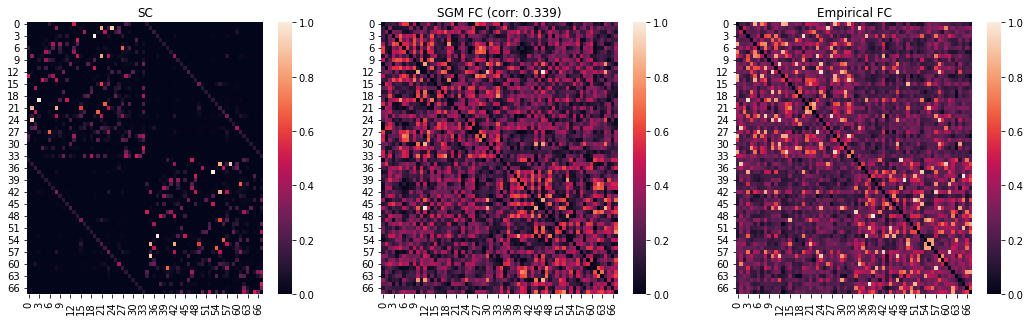

In [24]:
SC = brain.connectome[:68, :68]
SC_vec = _minmax_vec(SC[np.triu_indices(68, k = 1)])
est_FC_mm = _vec_2mat(est_vec)
obs_FC_mm = _vec_2mat(obs_vec)
SC_mm = _vec_2mat(SC_vec)

plt.figure(figsize=[18, 5])
plt.subplot(132)
plt.title(f"SGM FC (corr: {corr:.3f})")
sns.heatmap(est_FC_mm)
plt.subplot(133)
plt.title("Empirical FC")
sns.heatmap(obs_FC_mm)
#sns.heatmap(cur_obs_FC)
plt.subplot(131)
plt.title("SC")
sns.heatmap(SC_mm)

### Full Bayesian

In [55]:
cur_idx = 1
# get the cur brain
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT) # grabs distance matrix
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.connectome =  ind_conn[:, :, cur_idx] # re-assign connectome to individual connectome
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

_simulate_data_sp = partial(_simulate_data, 
                            brain=brain, 
                            prior_bds=paras.prior_bds, 
                            freqrange=paras.freqrange, 
                            diag_ws=paras.diag_ws)
_simulate_data_wrapper, _ = prepare_for_sbi(_simulate_data_sp, prior)

In [56]:
cur_posterior = load_pkl(sorted_fils[cur_idx])

_, cur_post_psds = simulate_for_sbi(_simulate_data_wrapper, cur_posterior,
                                    num_simulations=100, 
                                    num_workers=20)
cur_post_psds = cur_post_psds.reshape(-1, 68, 68);

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/newsgmws1_posteriorMRmul_alpha_num1000_densitynsf_MR3_noise_sd80_addv5/ind1.pkl


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

In [57]:
cur_obs_FC = np.abs(true_FC[:, :, cur_idx])
cur_est_FC = np.abs(cur_post_psds.mean(axis=0).numpy())
est_vec = _minmax_vec(cur_est_FC[np.triu_indices(68, k = 1)])
obs_vec = _minmax_vec(cur_obs_FC[np.triu_indices(68, k = 1)])
corr = scipy.stats.pearsonr(est_vec, obs_vec)[0]

0.4784209234478858

<AxesSubplot:title={'center':'SC'}>

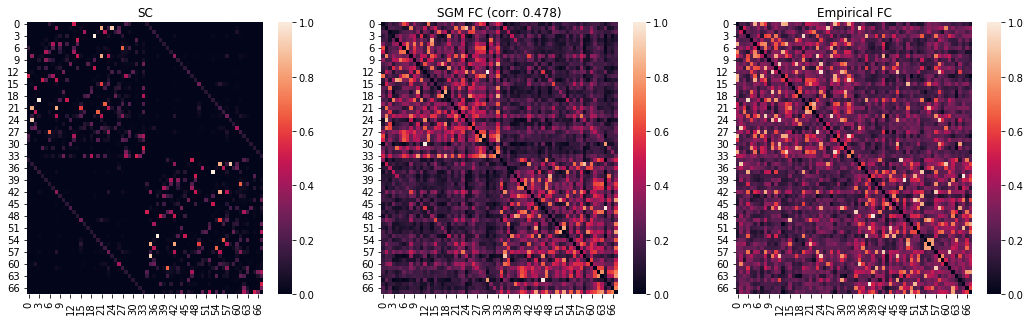

In [58]:
# no diag ws, only three sgm parameters
SC = brain.connectome[:68, :68]
SC_vec = _minmax_vec(SC[np.triu_indices(68, k = 1)])
est_FC_mm = _vec_2mat(est_vec)
obs_FC_mm = _vec_2mat(obs_vec)
SC_mm = _vec_2mat(SC_vec)

plt.figure(figsize=[18, 5])
plt.subplot(132)
plt.title(f"SGM FC (corr: {corr:.3f})")
sns.heatmap(est_FC_mm)
plt.subplot(133)
plt.title("Empirical FC")
sns.heatmap(obs_FC_mm)
#sns.heatmap(cur_obs_FC)
plt.subplot(131)
plt.title("SC")
sns.heatmap(SC_mm)

<AxesSubplot:title={'center':'SC'}>

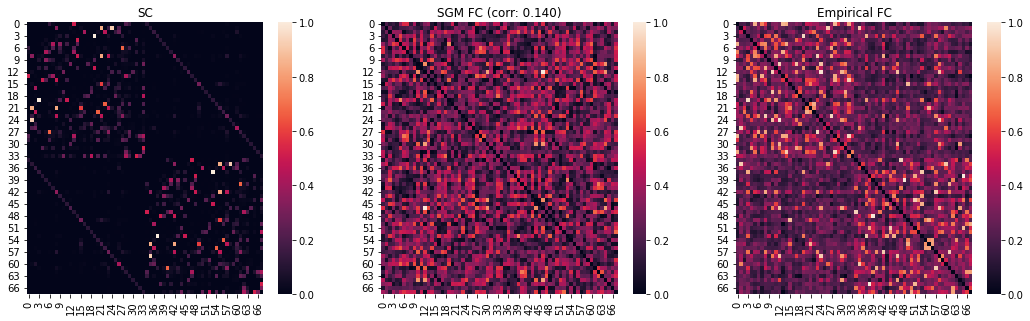

In [43]:
# diag ws, with first wight 0
SC = brain.connectome[:68, :68]
SC_vec = _minmax_vec(SC[np.triu_indices(68, k = 1)])
est_FC_mm = _vec_2mat(est_vec)
obs_FC_mm = _vec_2mat(obs_vec)
SC_mm = _vec_2mat(SC_vec)

plt.figure(figsize=[18, 5])
plt.subplot(132)
plt.title(f"SGM FC (corr: {corr:.3f})")
sns.heatmap(est_FC_mm)
plt.subplot(133)
plt.title("Empirical FC")
sns.heatmap(obs_FC_mm)
#sns.heatmap(cur_obs_FC)
plt.subplot(131)
plt.title("SC")
sns.heatmap(SC_mm)

<AxesSubplot:title={'center':'SC'}>

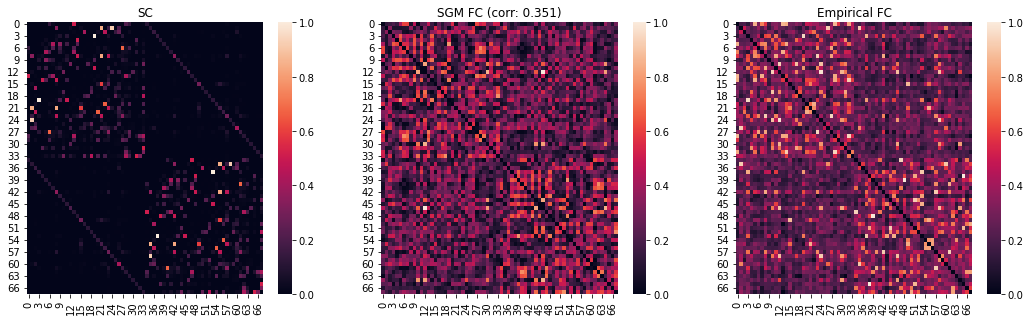

In [28]:
# diag ws, with first wight 1
SC = brain.connectome[:68, :68]
SC_vec = _minmax_vec(SC[np.triu_indices(68, k = 1)])
est_FC_mm = _vec_2mat(est_vec)
obs_FC_mm = _vec_2mat(obs_vec)
SC_mm = _vec_2mat(SC_vec)

plt.figure(figsize=[18, 5])
plt.subplot(132)
plt.title(f"SGM FC (corr: {corr:.3f})")
sns.heatmap(est_FC_mm)
plt.subplot(133)
plt.title("Empirical FC")
sns.heatmap(obs_FC_mm)
#sns.heatmap(cur_obs_FC)
plt.subplot(131)
plt.title("SC")
sns.heatmap(SC_mm)

## All data analysis

In [124]:
res_fils = list((RES_ROOT/paras.SBI_paras.save_dir).glob("ind*.pkl"))
_sorted_fn = lambda x: int(x.stem.split("ind")[-1][:])
sorted_fils = sorted(res_fils, key=_sorted_fn);

### Point est

In [125]:
inf_res = edict()
inf_res.est_FCs = []

corrs = []
for cur_idx in range(36):
    cur_posterior = load_pkl(sorted_fils[cur_idx], False)
    post_sps = cur_posterior.sample((1000, ))
    print(post_sps.shape)
    cur_est_paras = torch.median(post_sps, axis=0)[0]
        
    # get the cur brain
    brain = Brain.Brain()
    brain.add_connectome(DATA_ROOT) # grabs distance matrix
    brain.reorder_connectome(brain.connectome, brain.distance_matrix)
    brain.connectome =  ind_conn[:, :, cur_idx] # re-assign connectome to individual connectome
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()
        
    cur_obs_FC = np.abs(true_FC[:, :, cur_idx])
    cur_est_FC = np.abs(_paras_2FC(cur_est_paras, 
                                   brain=brain, 
                                   prior_bds=paras.prior_bds, 
                                   freqrange=paras.freqrange, 
                                   diag_ws=paras.diag_ws
                                  ))
    est_vec = _minmax_vec(cur_est_FC[np.triu_indices(68, k = 1)])
    obs_vec = _minmax_vec(cur_obs_FC[np.triu_indices(68, k = 1)])
    corr = scipy.stats.pearsonr(est_vec, obs_vec)[0]
    corrs.append(corr)
    inf_res.est_FCs.append(cur_est_FC)
inf_res.corrs = corrs
save_pkl(sorted_fils[0].parent/"inf_res.pkl", inf_res, True)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/newsgm_posteriorMRmul_theta_num1000_densitynsf_MR3_noise_sd80_addv5/inf_res.pkl


Text(0.5, 1.0, 'theta 0.128(0.004)')

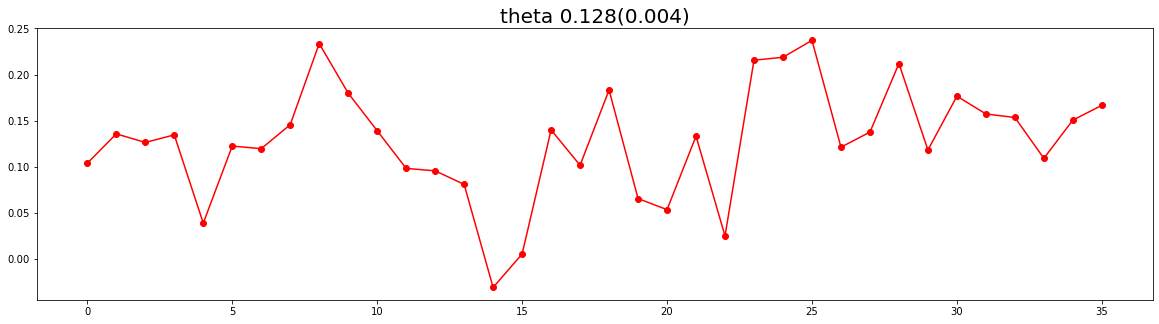

In [126]:
# 0.8, correct
plt.figure(figsize=[20, 5])
mcorr=np.mean(corrs)
plt.plot(corrs, "o-r")
plt.title(f"{paras.fc_type} {mcorr:.3f}({np.var(corrs):.3f})", fontsize=20)

### Full Bayesian

In [127]:
inf_res_fb = edict()
inf_res_fb.est_FCs = []

corrs_fb = []
for cur_idx in range(36):
# get the cur brain
    brain = Brain.Brain()
    brain.add_connectome(DATA_ROOT) # grabs distance matrix
    brain.reorder_connectome(brain.connectome, brain.distance_matrix)
    brain.connectome =  ind_conn[:, :, cur_idx] # re-assign connectome to individual connectome
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()
    
    _simulate_data_sp = partial(_simulate_data, 
                                brain=brain, 
                                prior_bds=paras.prior_bds, 
                                freqrange=paras.freqrange,
                                diag_ws=paras.diag_ws)
    _simulate_data_wrapper, _ = prepare_for_sbi(_simulate_data_sp, prior)
    
    cur_posterior = load_pkl(sorted_fils[cur_idx], False)
    tmp_sps, cur_post_fcs = simulate_for_sbi(_simulate_data_wrapper, cur_posterior,
                                        num_simulations=1000, 
                                        num_workers=50)
    print(cur_post_fcs.shape)
    cur_post_fcs = cur_post_fcs.reshape(-1, 68, 68)
    
    cur_obs_FC = np.abs(true_FC[:, :, cur_idx])
    cur_est_FC = np.abs(cur_post_fcs.mean(axis=0).numpy())
    est_vec = _minmax_vec(cur_est_FC[np.triu_indices(68, k = 1)])
    obs_vec = _minmax_vec(cur_obs_FC[np.triu_indices(68, k = 1)])
    corr = scipy.stats.pearsonr(est_vec, obs_vec)[0]
    corrs_fb.append(corr)
    inf_res_fb.est_FCs.append(cur_est_FC)
    
inf_res_fb.corrs = corrs_fb
save_pkl(sorted_fils[0].parent/"inf_res_fb.pkl", inf_res_fb)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4624])
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/newsgm_posteriorMRmul_theta_num1000_densitynsf_MR3_noise_sd80_addv5/inf_res_fb.pkl


Text(0.5, 1.0, 'theta 0.131(0.004)')

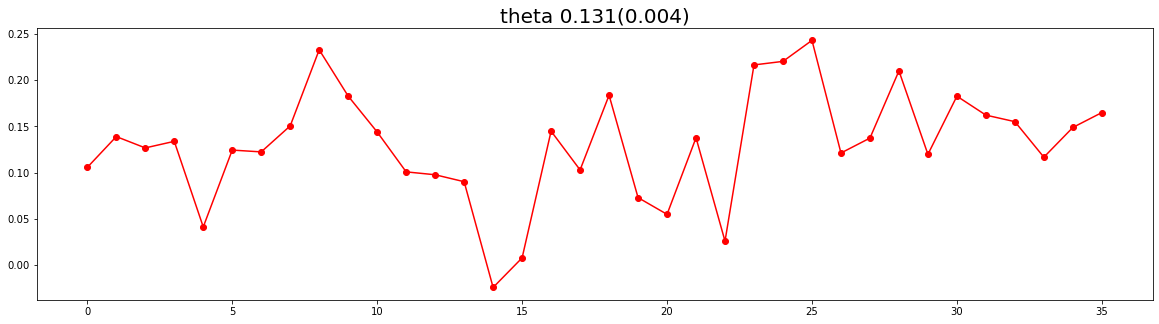

In [128]:
plt.figure(figsize=[20, 5])
mcorr=np.mean(corrs_fb)
plt.plot(corrs_fb, "o-r")
plt.title(f"{paras.fc_type} {mcorr:.3f}({np.var(corrs_fb):.3f})", fontsize=20)